In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2

## Get Test Dataset

In [2]:
from utils.preprocessing import get_mean_std, get_label_map, split_dataset

split_ratio = [0.7, 0.15, 0.15]
mean, std = get_mean_std('dataset_1500', split_ratio=split_ratio, random_seed=2024)

label_map = get_label_map('dataset_1500')

train_transform = transforms.Compose([
    v2.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandAugment(num_ops=2, magnitude=9),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    v2.Normalize(mean, std),
])

test_transform = transforms.Compose([
    v2.Normalize(mean, std),
])

_, _, test_dataset = split_dataset('dataset_1500',
                                    train_transform=train_transform,
                                    test_transform=test_transform,
                                    split_ratio=split_ratio,
                                    random_seed=2024)

print(f"test size: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Calculating mean and std: 100%|██████████| 99/99 [00:08<00:00, 11.03it/s]

test size: 675


## Load Pre-Trained Model

In [ ]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = models.efficientnet_v2_s()
print(model.classifier)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(128, 3)
)
print(model.classifier)

model.load_state_dict(torch.load('ckpts/effv2s_bn_si_0.001_10_0.5/best_val_acc.pth', map_location=device))
model.to(device)

## Testing

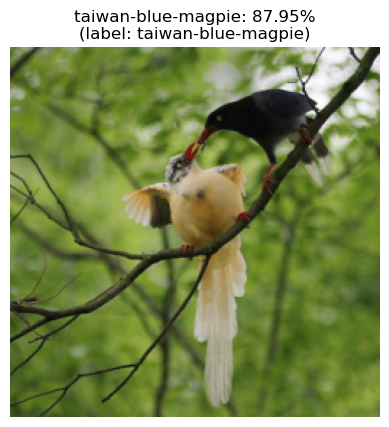

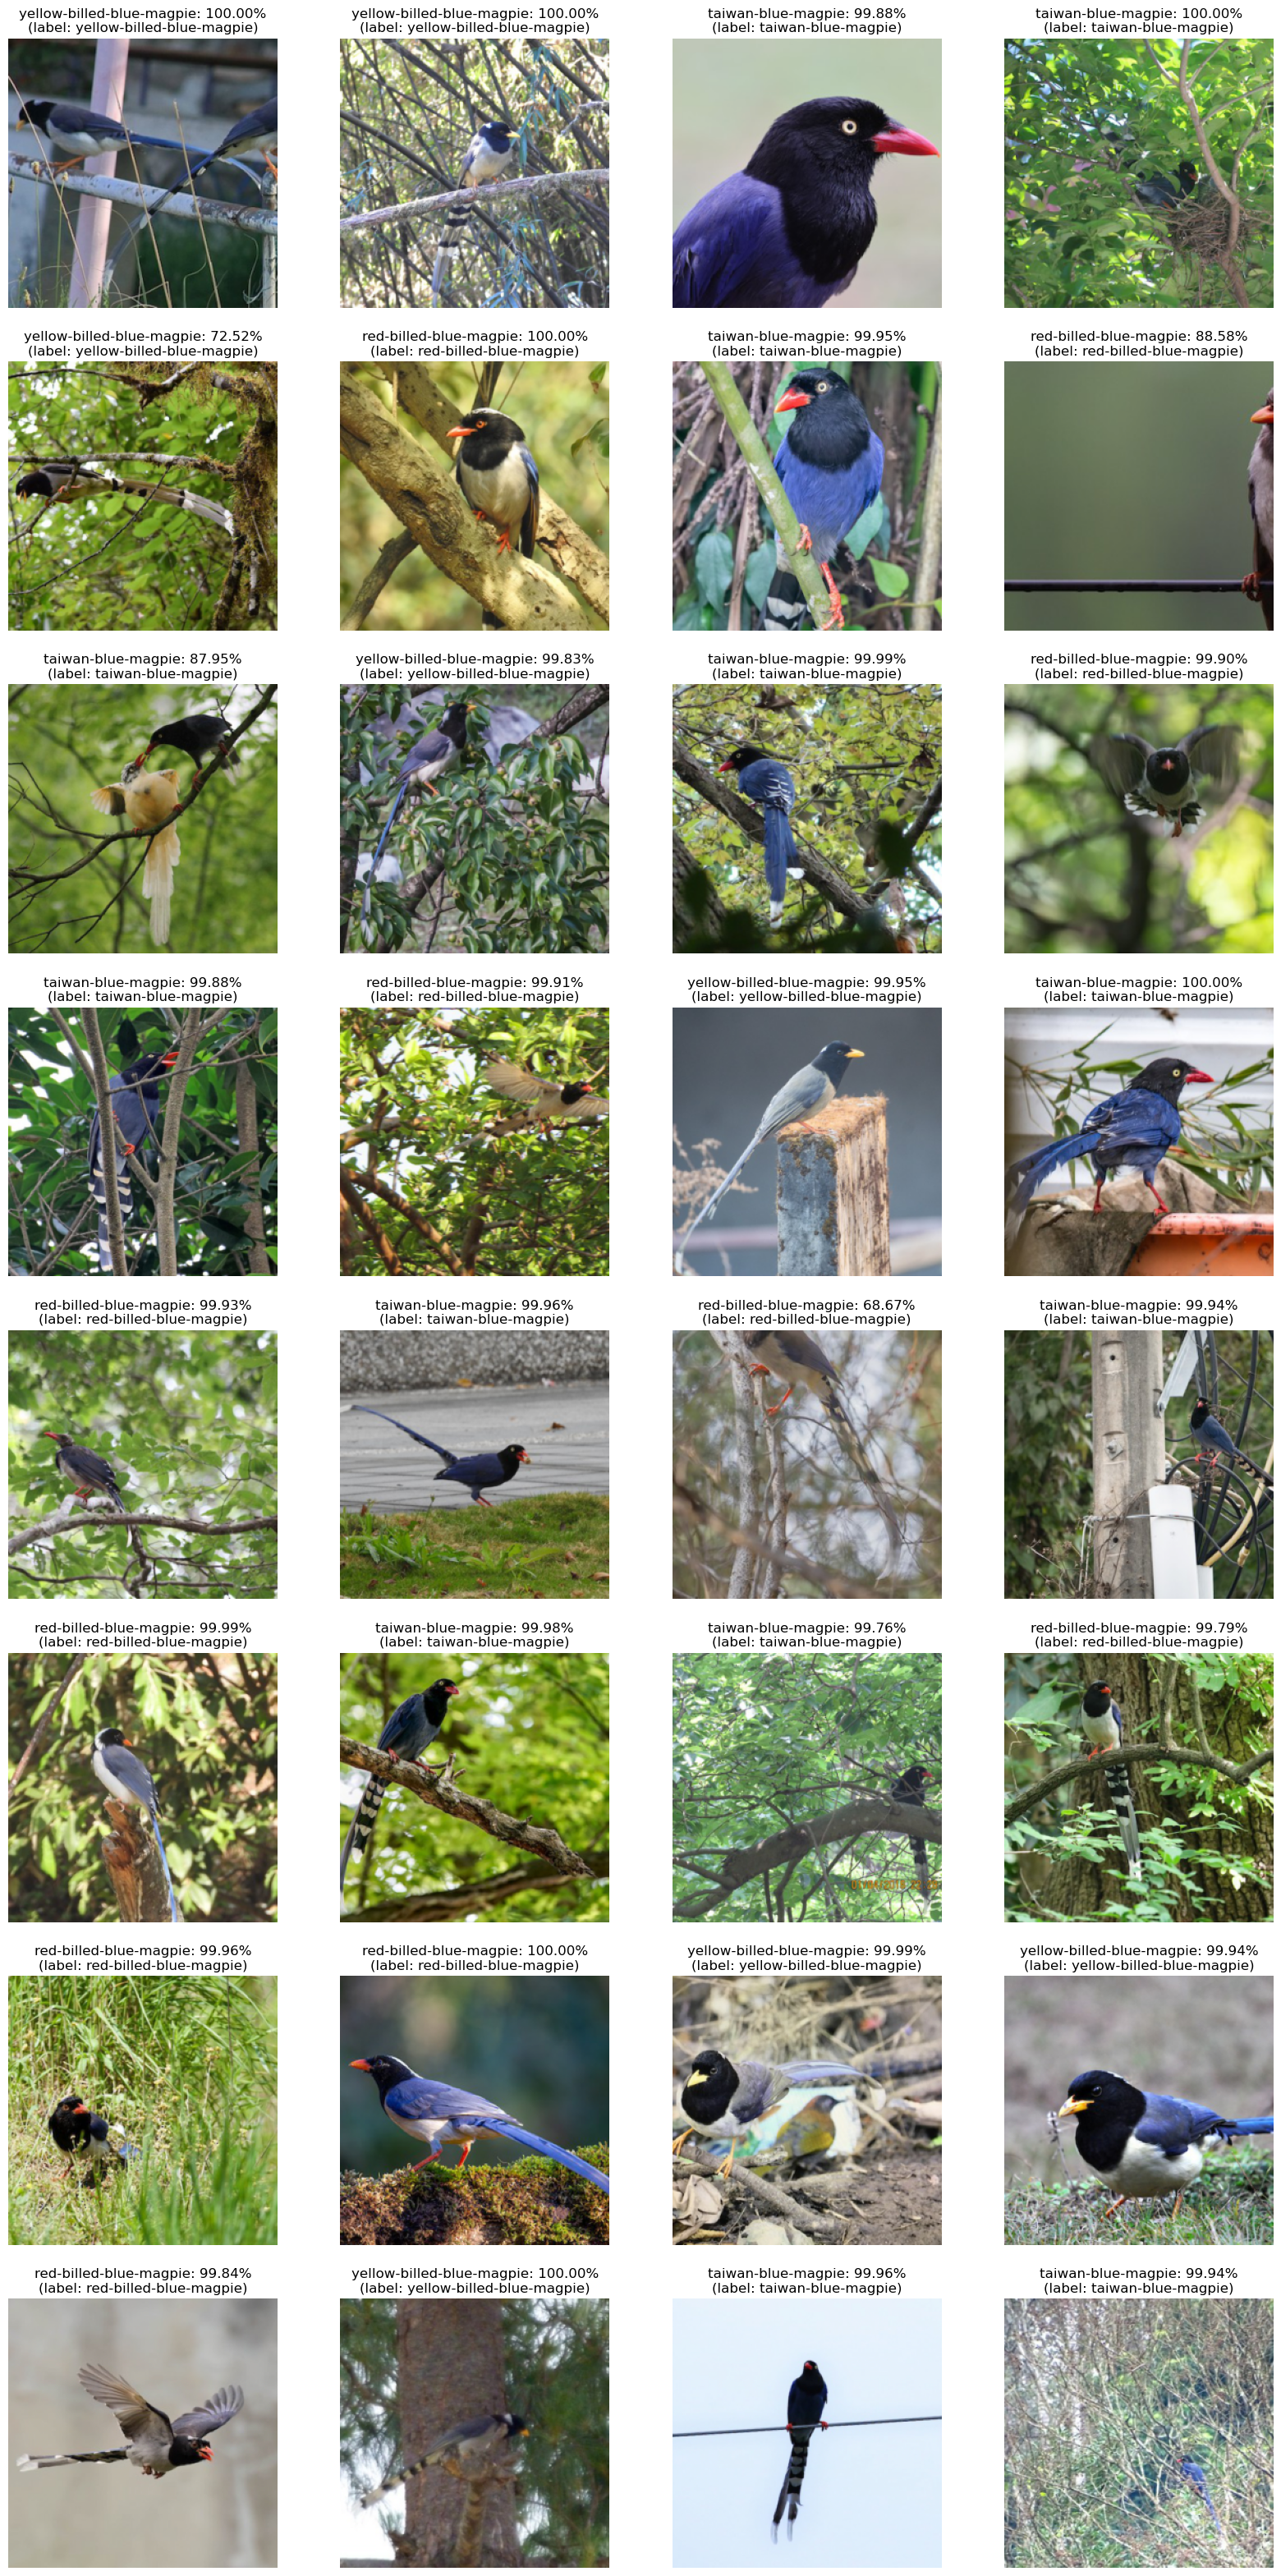

In [4]:
from utils.plot import plot_single_pred, plot_batch_pred
for images, labels in test_loader:
    images.to(device)
    
    plot_single_pred(model, images, labels, label_map, mean, std, device)
    plot_batch_pred(model, images, labels, label_map, mean, std, device)
    break

## Evaluation

In [5]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=label_map.values(), digits=4))

                           precision    recall  f1-score   support

   red-billed-blue-magpie     0.9696    0.9331    0.9510       239
       taiwan-blue-magpie     0.9567    0.9567    0.9567       231
yellow-billed-blue-magpie     0.9346    0.9756    0.9547       205

                 accuracy                         0.9541       675
                macro avg     0.9536    0.9551    0.9541       675
             weighted avg     0.9545    0.9541    0.9540       675

